In [ ]:
!pip install datasets[audio] librosa transformers

  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached triton-3.3.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.5 kB)
Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl (821.2 MB)
ERROR: Operation cancelled by user


In [ ]:
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
import torch, torchvision, torchaudio

print(torch.__version__)       # 2.6.0
print(torchvision.__version__) # 0.21.0
print(torchaudio.__version__)  # 2.6.0

2.6.0+cpu
0.21.0+cpu
2.6.0+cpu


In [ ]:
# Load the dataset in streaming mode and select necessary columns
from datasets import load_dataset

# Load the dataset without automatic audio decoding
ds = load_dataset("facebook/multilingual_librispeech", "french", split="train", streaming=True)

# Select columns to avoid automatic audio feature decoding by datasets
# We will load the audio manually with torchaudio
ds = ds.select_columns(["original_path", "begin_time", "end_time", "transcript", "audio_duration", "speaker_id", "chapter_id", "file", "id"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
print(next(iter(ds)))

{'original_path': 'http://www.archive.org/download/evangilestmarc-lemaistredesacy_1507_librivox/evangilestmarc_09_lemaistredesacy_64kb.mp3', 'begin_time': 28.64, 'end_time': 40.34, 'transcript': "ses vêtements devinrent tout brillants de lumière et blancs comme la neige en sorte qu'il n'y a point de foulon sur la terre qui puisse en faire d'aussi blancs", 'audio_duration': 11.700000000000005, 'speaker_id': '10065', 'chapter_id': '10039', 'file': '10065_10039_000000.opus', 'id': '10065_10039_000000'}


In [ ]:
# Take the first three examples from the training part and load audio manually

ds_head = []
for i, example in enumerate(ds):
    if i == 3:
        break
    # Manually load audio using torchaudio
    audio_path = example["original_path"] # Or construct path from 'file' if needed
    try:
      waveform, sample_rate = torchaudio.load(audio_path)
      example["audio"] = {"array": waveform.squeeze().numpy(), "sampling_rate": sample_rate}
      ds_head.append(example)
    except Exception as e:
      print(f"Error loading audio for {audio_path}: {e}")

In [ ]:
# Get the third example and explore it

example = list(ds_head)[-1]
example

{'original_path': 'http://www.archive.org/download/evangilestmarc-lemaistredesacy_1507_librivox/evangilestmarc_15_lemaistredesacy_64kb.mp3',
 'begin_time': 130.47,
 'end_time': 143.3,
 'transcript': 'enfin pilate voulant satisfaire le peuple leur délivra baba et ayant fait fouetter jésus il le livra pour être crucifié',
 'audio_duration': 12.830000000000013,
 'speaker_id': '10065',
 'chapter_id': '10039',
 'file': '10065_10039_000002.opus',
 'id': '10065_10039_000002',
 'audio': {'array': array([ 1.4277861e-05,  1.3025479e-05,  2.0066022e-05, ...,
          1.0848461e-05, -1.2064536e-05, -1.8304068e-05], dtype=float32),
  'sampling_rate': 22050}}

In [ ]:
import requests
from io import BytesIO

In [ ]:
# Load metadata
url = example['original_path']
begin_time = example['begin_time']
end_time = example['end_time']
target_rate = 16000

In [ ]:
# 1. Download the full audio file
response = requests.get(url)
full_waveform, sample_rate = torchaudio.load(BytesIO(response.content))  # shape: (1, n)

In [ ]:
# 2. Compute start and end sample indices
start_sample = int(begin_time * sample_rate)
end_sample = int(end_time * sample_rate)

In [ ]:
# 3. Crop the audio segment
segment = full_waveform[:, start_sample:end_sample]

In [ ]:
# 4. Resample if necessary
if sample_rate != target_rate:
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_rate)
    segment = resampler(segment)

In [ ]:
from IPython.display import Audio as IPyAudio
IPyAudio(segment.squeeze().numpy(), rate=target_rate)

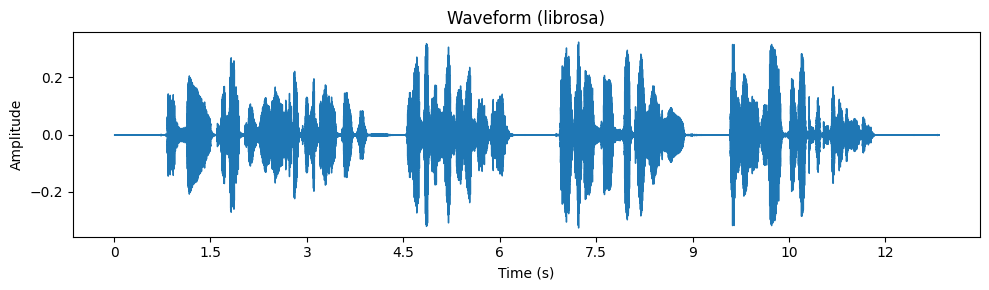

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Convert the segment to NumPy array
waveform_np = segment.squeeze().numpy()
sr = target_rate

plt.figure(figsize=(10, 3))
librosa.display.waveshow(waveform_np, sr=sr)
plt.title("Waveform (librosa)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

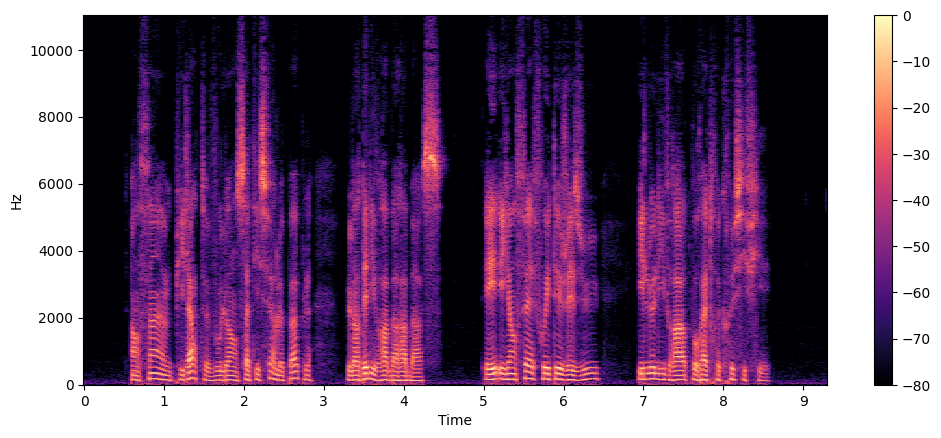

In [ ]:
# Spectrogram

import numpy as np

D = librosa.stft(waveform_np)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

In [ ]:
!pip uninstall triton -y

In [ ]:
from transformers.pipelines import pipeline

asr = pipeline("automatic-speech-recognition", model="Nhut/wav2vec2-large-xlsr-french")

Device set to use cpu


In [ ]:
# Compare the results

print(asr(waveform_np)['text'])
print(example["transcript"])

enfin pilate voulant satisfaire le peuple leur délivra barabass et ayant fait fouetter jésus il le livra pour être crucifié
enfin pilate voulant satisfaire le peuple leur délivra baba et ayant fait fouetter jésus il le livra pour être crucifié
